# Laboratório de detecção de faces em visão por computação - Notebook do aluno

Neste laboratório, você usará o Amazon Rekognition para realizar a detecção de uma face conhecida.

As etapas de alto nível que você executará neste laboratório são:

1. Criar uma coleção.

2. Fazer o upload de uma imagem de uma face que você deseja detectar no notebook do Amazon SageMaker.

3. Adicionar a imagem à coleção.

4. Visualizar a caixa delimitadora que foi criada para a imagem.

5. Relacionar as faces da coleção.

6. Usar a coleção para encontrar uma face.

7. Visualizar a caixa delimitadora da face que foi encontrada.

8. Excluir a coleção.

---

## Importação de pacotes do Python

Comece importando os pacotes do Python necessários.

No código a seguir:

- *matplotlib* fornece funções de plotagem
- *skimage* representa scikit-image, que fornece várias ferramentas úteis de manipulação de imagens
- *boto3* representa o AWS SDK para Python (Boto3), que é a biblioteca Python da AWS
- *numpy* representa NumPy, que é uma biblioteca para manipular dados
- *PIL* representa a Biblioteca de imagens do Python, que contém um conjunto de ferramentas para desenhar imagens


In [47]:
from skimage import io
from skimage.transform import rescale
from matplotlib import pyplot as plt

import boto3

import numpy as np

from PIL import Image, ImageDraw, ImageColor, ImageOps


## Tarefa 1: Criar uma coleção

Nesta tarefa, você cria uma coleção no Amazon Rekognition.

Você só precisa executar essa etapa uma vez.


In [48]:
client = boto3.client('rekognition')
collection_id = 'Collection'
response = client.create_collection(CollectionId=collection_id)
print(f"Collection ARN: {response['CollectionArn']}")
print(f"Status Code: {str(response['StatusCode'])}")
print("Feito")

ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreateCollection operation: The collection id: Collection already exists

In [49]:
filename = "foto.jpg"

faceimage = io.imread(filename)

plt.imshow(faceimage)


FileNotFoundError: No such file: '/home/ec2-user/SageMaker/pt_br/foto.jpg'


Certifique-se de que o tamanho da imagem seja inferior a 4096 x 4096 pixels. Se a imagem tiver um tamanho superior, você deverá redimensioná-la usando o seguinte código:

`faceimage = rescale(faceimage, 0.50, mode='constant')`

**Observação:** O valor numérico representa o fator a ser usado no dimensionamento. Um valor de *0,5* dimensionará a imagem para 50% do original.

Quando a imagem for redimensionada, salve o arquivo.

`io.imsave(filename, faceimage)`

**Dica:** você deve copiar o código em uma célula de código e executá-lo.


## Tarefa 3: Adicionar a imagem à coleção

Adicione a imagem à coleção que você criou anteriormente.


In [20]:
externalimageid = filename 

with open(filename, 'rb') as fimage:
    response = client.index_faces(CollectionId= collection_id,
                                 Image={'Bytes': fimage.read()},
                                  ExternalImageId=externalimageid,
                                  MaxFaces=1,
                                  QualityFilter="AUTO",
                                  DetectionAttributes=['ALL'])
print(f"Resultado para {filename}")
print(f"Faces indexadas:")
for faceRecord in response['FaceRecords']:
     print('  Face ID: ' + faceRecord['Face']['FaceId'])
     print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))


print("Faces Não indexadas:")
for unidexedFace in response['UnindexedFaces']:
    print(' Location: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
    print("   Razões:")
    for reason in unidexedFace['Reasons']:
        print(f"  {reason}")

Resultado para foto.jpg
Faces indexadas:
  Face ID: 8528bac5-b720-4786-b6e8-b0a297f50d7a
  Location: {'Width': 0.48980095982551575, 'Height': 0.38401854038238525, 'Left': 0.34334030747413635, 'Top': 0.363878458738327}
Faces Não indexadas:


## Tarefa 4: Visualizar a caixa delimitadora da face detectada

Se uma face tiver sido encontrada, os resultados deverão incluir o local da face que foi detectada. Examine a caixa delimitadora na imagem.

Para fazer isso, use a biblioteca PIL, que você importou anteriormente neste laboratório. Ao extrair a caixa delimitadora, você pode desenhar um conjunto de linhas em torno da imagem.


In [43]:
img = Image.open(filename)
imgWidth, imgHeight = img.size

draw = ImageDraw.Draw(img)
for faceRecord in response['FaceRecords']:
    box = faceRecord['Face']['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']
    
    points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height), (left,top))
    
    draw.line(points,fill='#d40000', width=15)
    
plt.imshow(img)
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/SageMaker/pt_br/foto.jpg'

## Tarefa 5: Listar faces na coleção

Examine a imagem que você tem na coleção. 



In [26]:
maxResults = 2 
faces_count = 0 
tokens = True

response = client.list_faces(CollectionId=collection_id,
                            MaxResults=maxResults)

print( 'Faces na coleção ' + collection_id)

while tokens:
    faces=response['Faces']
    
    for face in faces:
        print(face)
        faces_count+=1
    if 'NextToken' in response:
        nextToken=response['NextToken']
        response=client.list_faces(CollectionId=collection_id,
                                  NextToken=nextToken, 
                                   MaxResults=maxResults)
    else:
        tokens=False

Faces na coleção Collection
{'FaceId': '8528bac5-b720-4786-b6e8-b0a297f50d7a', 'BoundingBox': {'Width': 0.48980098962783813, 'Height': 0.38401898741722107, 'Left': 0.3433400094509125, 'Top': 0.3638780117034912}, 'ImageId': '265a18da-e1bf-30e5-93cd-2339d9c47daa', 'ExternalImageId': 'foto.jpg', 'Confidence': 99.9990005493164, 'IndexFacesModelVersion': '7.0'}
{'FaceId': 'd2f9aa28-83b4-43f4-9ffb-10aecf508c05', 'BoundingBox': {'Width': 0.34836500883102417, 'Height': 0.3531210124492645, 'Left': 0.30951398611068726, 'Top': 0.11020100116729736}, 'ImageId': '59d87d59-b733-306a-94e8-0670b0a8dcdd', 'ExternalImageId': 'mum.jpg', 'Confidence': 99.99430084228516, 'IndexFacesModelVersion': '7.0'}


## Tarefa 6: Encontrar uma face usando a coleção

Nesta etapa, você usará a coleção para detectar uma face em uma imagem.

Use a imagem de exemplo fornecida denominada *target.jpg* e faça o upload dela para este notebook.



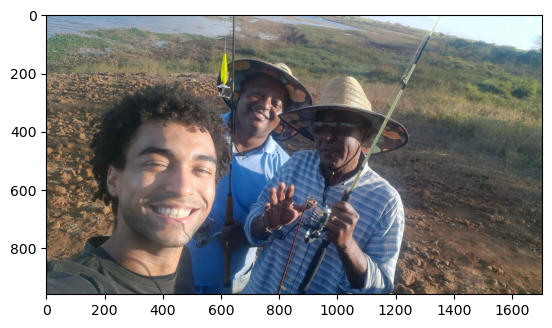

In [27]:
targetfilename = "target.jpg"

targetimage = Image.open(targetfilename)
plt.imshow(targetimage)

Em seguida, chame a operação `search_faces_by_image` e veja se obtém uma correspondência.

In [30]:
threshold = 70
maxFaces = 3

with open(targetfilename, 'rb') as timage:
    response2 = client.search_faces_by_image(CollectionId=collection_id,
                                           Image={'Bytes': timage.read()},
                                           FaceMatchThreshold=threshold,
                                           MaxFaces=maxFaces)
faceMatches = response2['FaceMatches']
print("Rostos que correspondem")
for match in faceMatches:
    print('FaceId' +match['Face']['FaceId'])
    print('Similaridade: ' +"{:.2f}".format(match['Similarity']) + "%" )
    print('ExternalImageId' + match['Face']['ExternalImageId'])
    

Rostos que correspondem
FaceId8528bac5-b720-4786-b6e8-b0a297f50d7a
Similaridade: 99.97%
ExternalImageIdfoto.jpg


## Tarefa 7: Desenhar uma caixa delimitadora em torno da face descoberta

Desenhe uma caixa delimitadora em torno da face descoberta.

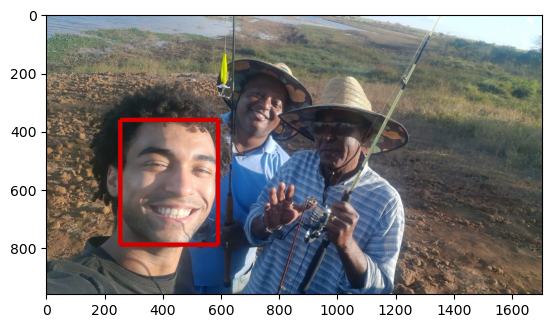

In [42]:
imgWidth, imgHeight = targetimage.size

draw = ImageDraw.Draw(targetimage)

box = response2['SearchedFaceBoundingBox']
left= imgWidth * box['Left']
top = imgHeight * box['Top']
width = imgWidth * box['Width']
height = imgHeight * box['Height']

points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height), (left,top))
draw.line(points,fill='#d40000', width=15)

plt.imshow(targetimage)

## Tarefa 8: Excluir a coleção

Quando terminar, exclua a coleção. Para fazer isso, execute o código a seguir. 


In [ ]:
print('Attempting to delete collection ' + collection_id)
status_code=0
try:
    response=client.delete_collection(CollectionId=collection_id)
    status_code=response['StatusCode']
    print('All done!')
    print(status_code)
    
except ClientError as e:
    if e.response['Error']['Code'] == 'ResourceNotFoundException':
        print ('The collection ' + collection_id + ' was not found ')
    else:
        print ('Error other than Not Found occurred: ' + e.response['Error']['Message'])
    status_code=e.response['ResponseMetadata']['HTTPStatusCode']



# Parabéns!

Você concluiu este laboratório e agora pode encerrá-lo seguindo as instruções do guia do laboratório.